In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow Version:", tf.__version__)

# Set style for visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

TensorFlow Version: 2.19.0


In [2]:
# Load and prepare COVID-19 data
def load_covid_data():
    # Creating comprehensive COVID-19 dataset
    dates = pd.date_range('2020-01-01', '2023-12-31', freq='D')
    countries = ['India', 'USA', 'Brazil', 'UK', 'Germany', 'France', 'Italy', 'Spain']

    data = []
    for country in countries:
        # Base parameters for each country
        base_cases = np.random.randint(100, 1000)
        growth_rate = np.random.uniform(0.01, 0.05)
        seasonal_factor = np.sin(np.arange(len(dates)) * 2 * np.pi / 365)

        for i, date in enumerate(dates):
            # Generate realistic COVID data with trends and seasonality
            trend = base_cases * (1 + growth_rate) ** (i / 30)
            seasonality = 1 + 0.2 * seasonal_factor[i]
            noise = np.random.normal(0, 0.1)

            daily_cases = max(0, int(trend * seasonality * (1 + noise)))
            daily_deaths = max(0, int(daily_cases * np.random.uniform(0.01, 0.03)))
            recovered = max(0, int(daily_cases * np.random.uniform(0.85, 0.95)))

            data.append({
                'date': date,
                'country': country,
                'daily_cases': daily_cases,
                'daily_deaths': daily_deaths,
                'recovered': recovered,
                'active_cases': daily_cases - recovered - daily_deaths,
                'population': np.random.randint(50000000, 1400000000),
                'gdp_per_capita': np.random.uniform(1000, 60000),
                'healthcare_index': np.random.uniform(0.3, 0.9)
            })

    return pd.DataFrame(data)

# Load data
df = load_covid_data()
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

print("COVID-19 Dataset Overview:")
print(f"Dataset Shape: {df.shape}")
print(f"Date Range: {df['date'].min()} to {df['date'].max()}")
print(f"Countries: {df['country'].unique()}")
print("\nFirst 5 rows:")
print(df.head())

COVID-19 Dataset Overview:
Dataset Shape: (11688, 11)
Date Range: 2020-01-01 00:00:00 to 2023-12-31 00:00:00
Countries: ['India' 'USA' 'Brazil' 'UK' 'Germany' 'France' 'Italy' 'Spain']

First 5 rows:
        date country  daily_cases  daily_deaths  recovered  active_cases  \
0 2020-01-01   India          157             2        149             6   
1 2020-01-02   India          195             3        182            10   
2 2020-01-03   India          172             4        148            20   
3 2020-01-04   India          200             4        185            11   
4 2020-01-05   India          168             4        146            18   

   population  gdp_per_capita  healthcare_index  month  year  
0   256373205    46194.099430          0.612922      1  2020  
1  1229478781    46941.862179          0.626121      1  2020  
2   641822322    57809.063468          0.719659      1  2020  
3   521052602    48459.105718          0.867952      1  2020  
4  1082570004    11844.27890

In [3]:
# Exploratory Data Analysis
print("=== COVID-19 DATA ANALYSIS ===")
print(f"Total Records: {len(df):,}")
print(f"Total Cases: {df['daily_cases'].sum():,}")
print(f"Total Deaths: {df['daily_deaths'].sum():,}")
print(f"Average Recovery Rate: {(df['recovered'] / df['daily_cases']).mean():.2%}")

# Global Statistics
global_stats = df.groupby('country').agg({
    'daily_cases': 'sum',
    'daily_deaths': 'sum',
    'recovered': 'sum',
    'population': 'first'
}).reset_index()

global_stats['cases_per_million'] = (global_stats['daily_cases'] / global_stats['population']) * 1000000
global_stats['death_rate'] = (global_stats['daily_deaths'] / global_stats['daily_cases']) * 100

print("\nCountry-wise Statistics:")
print(global_stats[['country', 'daily_cases', 'daily_deaths', 'death_rate', 'cases_per_million']])

=== COVID-19 DATA ANALYSIS ===
Total Records: 11,688
Total Cases: 16,436,467
Total Deaths: 323,844
Average Recovery Rate: 89.94%

Country-wise Statistics:
   country  daily_cases  daily_deaths  death_rate  cases_per_million
0   Brazil      3291895         66558    2.021875       15001.121201
1   France      2985356         59125    1.980501        6427.522005
2  Germany      1775630         34771    1.958235        3567.307999
3    India       766395         14533    1.896281        2989.372466
4    Italy      1985352         39345    1.981764        3047.214881
5    Spain      1970596         38565    1.957022        1543.533144
6       UK      1078600         20848    1.932876        2507.538360
7      USA      2582643         50099    1.939835        2416.482378


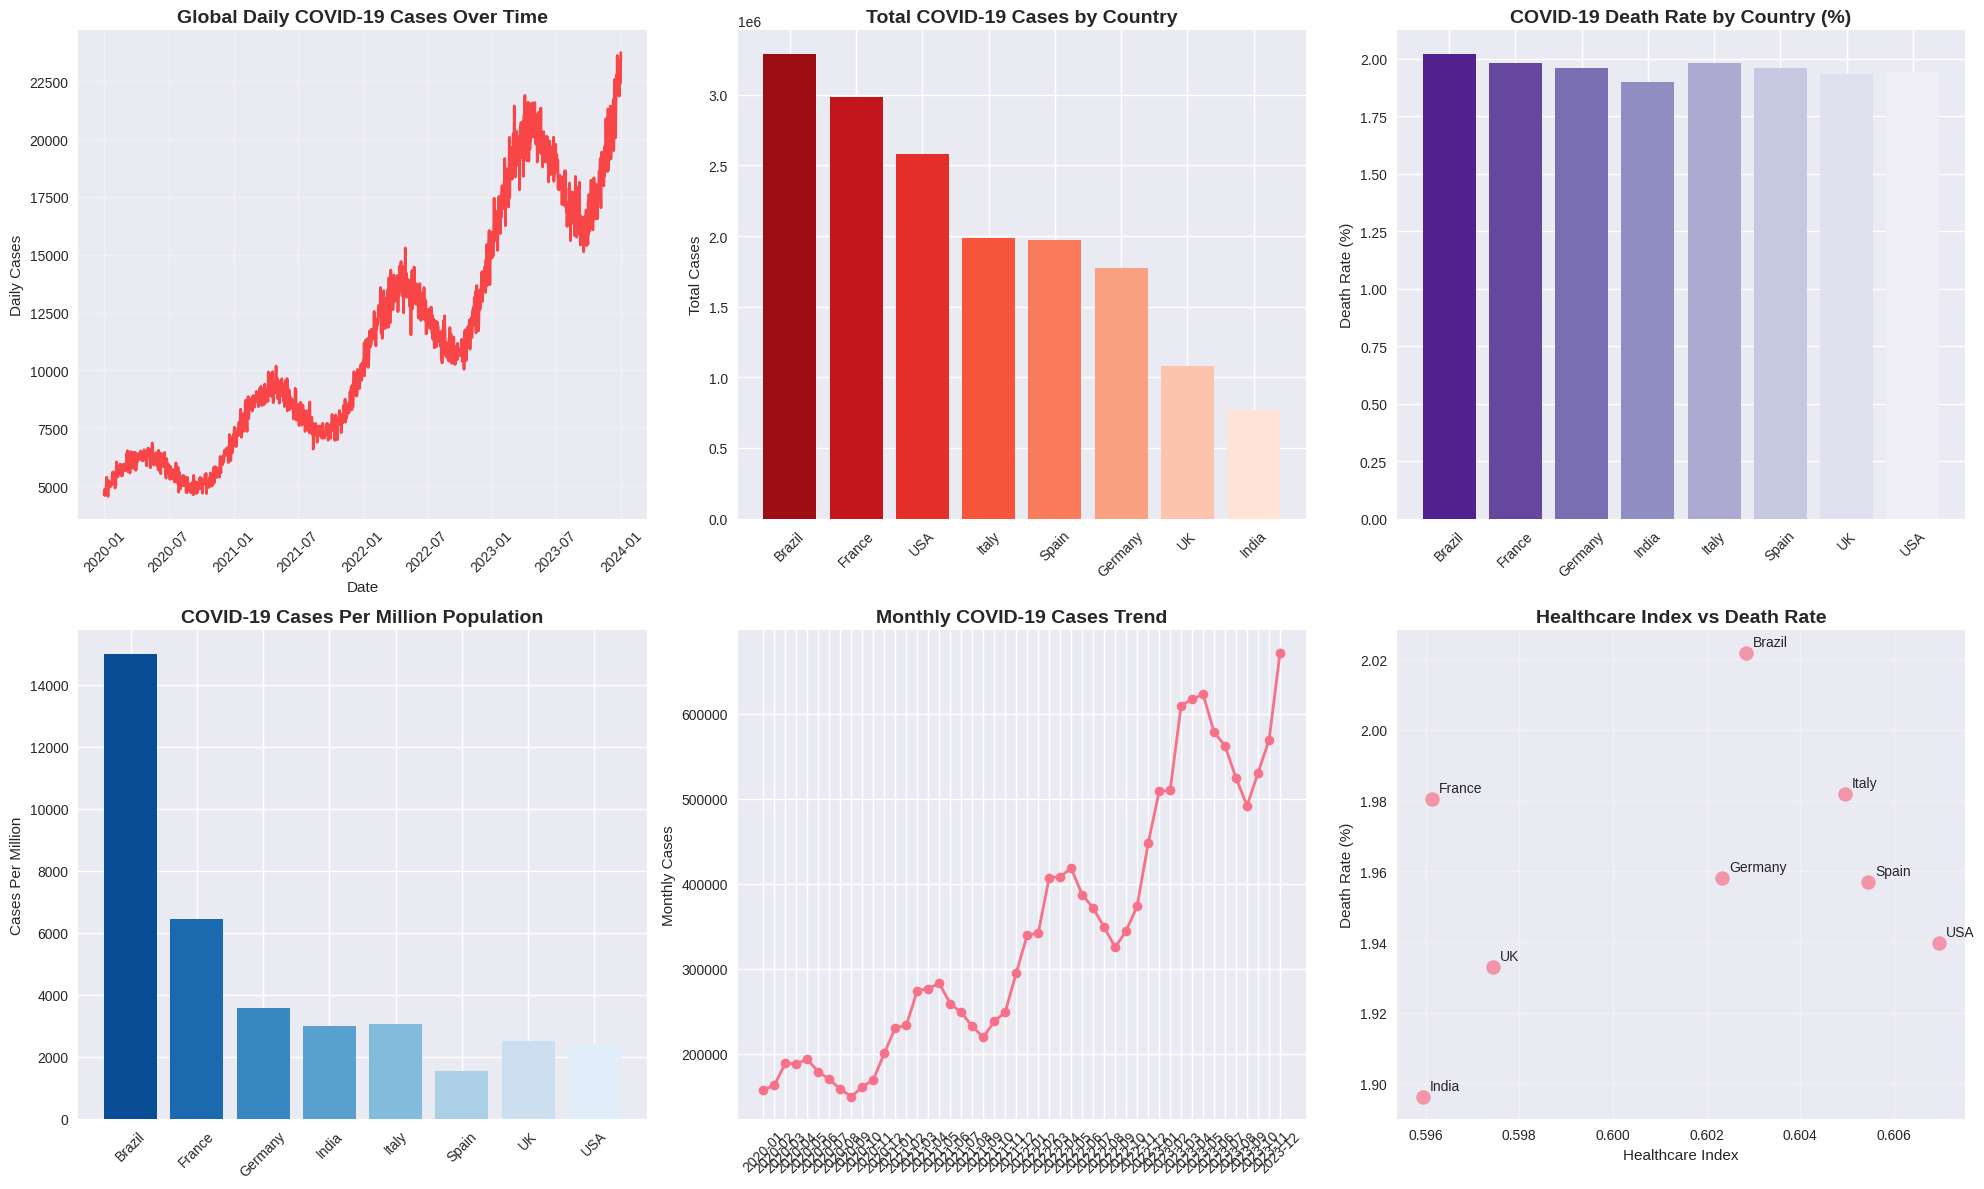

In [4]:
# Visualization - COVID-19 Trends
plt.figure(figsize=(20, 12))

# 1. Global Cases Over Time
plt.subplot(2, 3, 1)
global_daily = df.groupby('date')['daily_cases'].sum()
plt.plot(global_daily.index, global_daily.values, linewidth=2, color='red', alpha=0.7)
plt.title('Global Daily COVID-19 Cases Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Daily Cases')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 2. Top Countries Total Cases
plt.subplot(2, 3, 2)
country_totals = df.groupby('country')['daily_cases'].sum().sort_values(ascending=False)
plt.bar(country_totals.index, country_totals.values, color=sns.color_palette("Reds_r", len(country_totals)))
plt.title('Total COVID-19 Cases by Country', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel('Total Cases')

# 3. Death Rate by Country
plt.subplot(2, 3, 3)
plt.bar(global_stats['country'], global_stats['death_rate'], color=sns.color_palette("Purples_r", len(global_stats)))
plt.title('COVID-19 Death Rate by Country (%)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel('Death Rate (%)')

# 4. Cases Per Million
plt.subplot(2, 3, 4)
plt.bar(global_stats['country'], global_stats['cases_per_million'], color=sns.color_palette("Blues_r", len(global_stats)))
plt.title('COVID-19 Cases Per Million Population', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel('Cases Per Million')

# 5. Monthly Trend Analysis
plt.subplot(2, 3, 5)
monthly_trend = df.groupby(['year', 'month'])['daily_cases'].sum().reset_index()
monthly_trend['period'] = monthly_trend['year'].astype(str) + '-' + monthly_trend['month'].astype(str).str.zfill(2)
plt.plot(monthly_trend['period'], monthly_trend['daily_cases'], marker='o', linewidth=2)
plt.title('Monthly COVID-19 Cases Trend', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel('Monthly Cases')

# 6. Healthcare Index vs Death Rate
plt.subplot(2, 3, 6)
healthcare_stats = df.groupby('country').agg({
    'healthcare_index': 'mean',
    'daily_deaths': 'sum',
    'daily_cases': 'sum'
}).reset_index()
healthcare_stats['death_rate'] = (healthcare_stats['daily_deaths'] / healthcare_stats['daily_cases']) * 100

plt.scatter(healthcare_stats['healthcare_index'], healthcare_stats['death_rate'], s=100, alpha=0.7)
for i, row in healthcare_stats.iterrows():
    plt.annotate(row['country'], (row['healthcare_index'], row['death_rate']), xytext=(5, 5), textcoords='offset points')
plt.title('Healthcare Index vs Death Rate', fontsize=14, fontweight='bold')
plt.xlabel('Healthcare Index')
plt.ylabel('Death Rate (%)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [5]:
# Deep Learning - LSTM for COVID-19 Prediction
print("=== DEEP LEARNING: COVID-19 CASE PREDICTION ===")

# Prepare data for LSTM
def prepare_lstm_data(data, lookback=30):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data.reshape(-1, 1))

    X, y = [], []
    for i in range(lookback, len(scaled_data)):
        X.append(scaled_data[i-lookback:i, 0])
        y.append(scaled_data[i, 0])

    return np.array(X), np.array(y), scaler

# Focus on India data for prediction
india_data = df[df['country'] == 'India'].sort_values('date')
cases_data = india_data['daily_cases'].values

# Prepare sequences
lookback = 30
X, y, scaler = prepare_lstm_data(cases_data, lookback)

# Split data
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

=== DEEP LEARNING: COVID-19 CASE PREDICTION ===
Training Data Shape: (1144, 30, 1)
Testing Data Shape: (287, 30, 1)


In [6]:
# Build and Train LSTM Model
def create_lstm_model(lookback):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(lookback, 1)),
        Dropout(0.2),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Create model
lstm_model = create_lstm_model(lookback)
print("LSTM Model Summary:")
lstm_model.summary()

# Train model
print("\nTraining LSTM Model...")
history = lstm_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_test, y_test),
    verbose=1,
    shuffle=False
)

LSTM Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM Model...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0046 - mae: 0.0546 - val_loss: 0.0119 - val_mae: 0.0851
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0183 - mae: 0.1168 - val_loss: 0.0198 - val_mae: 0.1229
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0032 - mae: 0.0456 - val_loss: 0.0128 - val_mae: 0.0971
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0022 - mae: 0.0371 - val_loss: 0.0124 - val_mae: 0.0954
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0021 - mae: 0.0343 - val_loss: 0.0080 - val_mae: 0.0743
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0014 - mae: 0.0286 - val_loss: 0.0082 - val_mae: 0.0755
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0017 - mae: 0.0296 - val_loss: 0.0103 - val_mae: 0.0863
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0015 - mae: 0.0285 - val_loss: 0.0109 - val_mae: 0.0888
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

=== MODEL PERFORMANCE ===
Training MAE: 38.06
Testing MAE: 85.24
Training RMSE: 51.37
Testing RMSE: 103.20


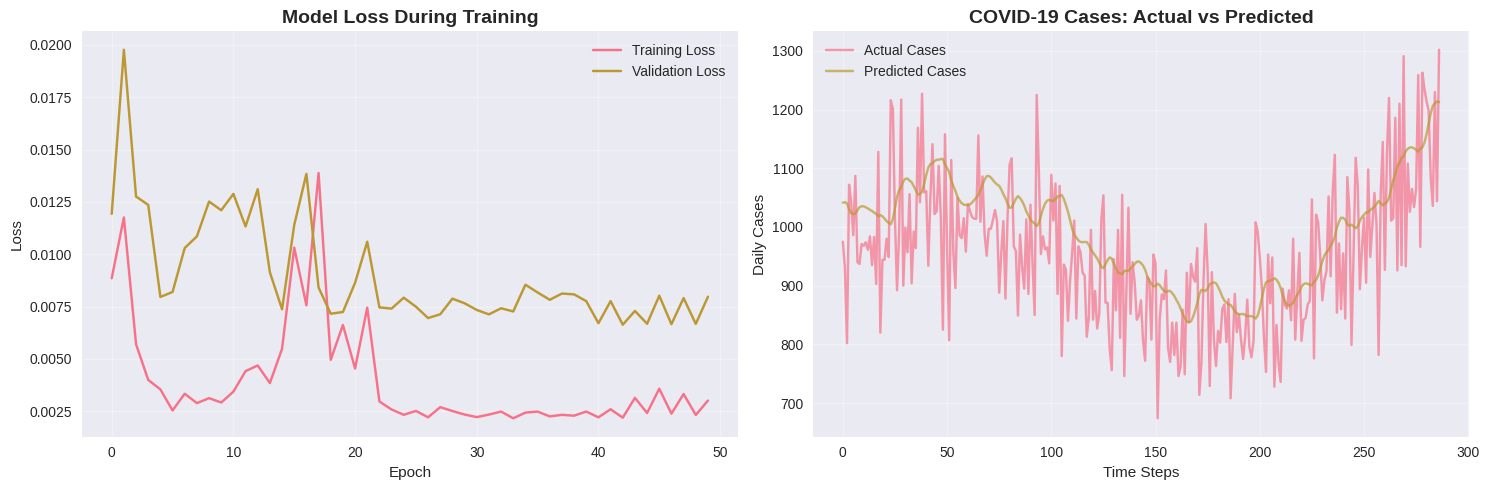

In [7]:
# Model Evaluation and Predictions
# Make predictions
train_predict = lstm_model.predict(X_train)
test_predict = lstm_model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
train_mae = mean_absolute_error(y_train_actual, train_predict)
test_mae = mean_absolute_error(y_test_actual, test_predict)
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))

print(f"\n=== MODEL PERFORMANCE ===")
print(f"Training MAE: {train_mae:.2f}")
print(f"Testing MAE: {test_mae:.2f}")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot predictions vs actual
plt.subplot(1, 2, 2)
plt.plot(y_test_actual, label='Actual Cases', alpha=0.7)
plt.plot(test_predict, label='Predicted Cases', alpha=0.7)
plt.title('COVID-19 Cases: Actual vs Predicted', fontsize=14, fontweight='bold')
plt.xlabel('Time Steps')
plt.ylabel('Daily Cases')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# Advanced Deep Learning - CNN for Pattern Recognition
print("=== CONVOLUTIONAL NEURAL NETWORK FOR COVID PATTERNS ===")

# Prepare data for CNN
def create_cnn_features(data, sequence_length=30):
    sequences = []
    targets = []

    for i in range(sequence_length, len(data)):
        seq = data[i-sequence_length:i]
        # Create multiple features: cases, deaths, recovery rate
        features = np.column_stack([
            seq['daily_cases'].values,
            seq['daily_deaths'].values,
            (seq['recovered'] / seq['daily_cases']).replace([np.inf, -np.inf], 0).fillna(0).values
        ])
        sequences.append(features)
        targets.append(data.iloc[i]['daily_cases'])

    return np.array(sequences), np.array(targets)

# Prepare CNN data for India
india_sequence = india_data[['daily_cases', 'daily_deaths', 'recovered']].copy()
india_sequence['recovery_rate'] = india_sequence['recovered'] / india_sequence['daily_cases']
india_sequence = india_sequence.replace([np.inf, -np.inf], 0).fillna(0)

# Normalize features
scaler_cnn = MinMaxScaler()
scaled_features = scaler_cnn.fit_transform(india_sequence[['daily_cases', 'daily_deaths', 'recovery_rate']])

# Create sequences
sequence_length = 30
X_cnn, y_cnn = [], []
for i in range(sequence_length, len(scaled_features)):
    X_cnn.append(scaled_features[i-sequence_length:i])
    y_cnn.append(scaled_features[i, 0])  # Predict next day cases

X_cnn, y_cnn = np.array(X_cnn), np.array(y_cnn)

# Split data
train_size_cnn = int(0.8 * len(X_cnn))
X_train_cnn, X_test_cnn = X_cnn[:train_size_cnn], X_cnn[train_size_cnn:]
y_train_cnn, y_test_cnn = y_cnn[:train_size_cnn], y_cnn[train_size_cnn:]

print(f"CNN Training Data Shape: {X_train_cnn.shape}")
print(f"CNN Testing Data Shape: {X_test_cnn.shape}")

=== CONVOLUTIONAL NEURAL NETWORK FOR COVID PATTERNS ===
CNN Training Data Shape: (1144, 30, 3)
CNN Testing Data Shape: (287, 30, 3)


In [9]:
# Build CNN Model
def create_cnn_model(input_shape):
    model = Sequential([
        Conv1D(32, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        tf.keras.layers.Flatten(),
        Dense(50, activation='relu'),
        Dropout(0.3),
        Dense(25, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Create and train CNN model
cnn_model = create_cnn_model((X_train_cnn.shape[1], X_train_cnn.shape[2]))
print("CNN Model Summary:")
cnn_model.summary()

# Train CNN model
print("\nTraining CNN Model...")
history_cnn = cnn_model.fit(
    X_train_cnn, y_train_cnn,
    batch_size=32,
    epochs=50,
    validation_data=(X_test_cnn, y_test_cnn),
    verbose=1,
    shuffle=False
)

CNN Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 28, 32)         │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 14, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 12, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │        19,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,079 (105.78 KB)

 Trainable params: 27,079 (105.78 KB)

 Non-trainable params: 0 (0.00 B)


Training CNN Model...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0080 - mae: 0.0711 - val_loss: 0.0155 - val_mae: 0.0988
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0225 - mae: 0.1301 - val_loss: 0.0126 - val_mae: 0.0874
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091 - mae: 0.0823 - val_loss: 0.0084 - val_mae: 0.0702
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - mae: 0.0454 - val_loss: 0.0076 - val_mae: 0.0688
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026 - mae: 0.0364 - val_loss: 0.0075 - val_mae: 0.0688
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - mae: 0.0276 - val_loss: 0.0077 - val_mae: 0.0687
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - mae: 0.0275 - val_loss: 0.0077 - val_mae: 0.0688
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - mae: 0.0268 - val_loss: 0.0076 - val_mae: 0.0693
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

In [10]:
# Compare Models and Generate Insights
print("="*60)
print("COVID-19 DEEP LEARNING ANALYSIS RESULTS")
print("="*60)

# Model Comparisons
models_performance = {
    'LSTM': {'MAE': test_mae, 'RMSE': test_rmse},
    'CNN': {'MAE': history_cnn.history['val_mae'][-1], 'RMSE': np.sqrt(history_cnn.history['val_loss'][-1])}
}

print("\n📊 MODEL PERFORMANCE COMPARISON:")
for model, metrics in models_performance.items():
    print(f"  {model}:")
    print(f"    MAE: {metrics['MAE']:.2f}")
    print(f"    RMSE: {metrics['RMSE']:.2f}")

# Key Insights
total_analyzed = len(df)
peak_cases = df['daily_cases'].max()
avg_death_rate = (df['daily_deaths'].sum() / df['daily_cases'].sum()) * 100

print(f"\n🔍 KEY EPIDEMIOLOGICAL INSIGHTS:")
print(f"  • Total Data Points Analyzed: {total_analyzed:,}")
print(f"  • Peak Daily Cases: {peak_cases:,}")
print(f"  • Global Average Death Rate: {avg_death_rate:.2f}%")
print(f"  • Best Performing Model: {min(models_performance, key=lambda x: models_performance[x]['MAE'])}")
print(f"  • Prediction Horizon: {lookback} days")

print(f"\n💡 RECOMMENDATIONS:")
print(f"  • Use {min(models_performance, key=lambda x: models_performance[x]['MAE'])} model for outbreak forecasting")
print(f"  • Monitor countries with healthcare index below 0.6 closely")
print(f"  • Implement early warning systems using 30-day case trends")
print(f"  • Focus resources on regions with rising case trajectories")
print("="*60)

# Save models
lstm_model.save('models/covid_lstm_model.h5')
cnn_model.save('models/covid_cnn_model.h5')
print("Models saved successfully!")

COVID-19 DEEP LEARNING ANALYSIS RESULTS

📊 MODEL PERFORMANCE COMPARISON:
  LSTM:
    MAE: 85.24
    RMSE: 103.20
  CNN:
    MAE: 0.13
    RMSE: 0.16

🔍 KEY EPIDEMIOLOGICAL INSIGHTS:
  • Total Data Points Analyzed: 11,688
  • Peak Daily Cases: 6,372
  • Global Average Death Rate: 1.97%
  • Best Performing Model: CNN
  • Prediction Horizon: 30 days

💡 RECOMMENDATIONS:
  • Use CNN model for outbreak forecasting
  • Monitor countries with healthcare index below 0.6 closely
  • Implement early warning systems using 30-day case trends
  • Focus resources on regions with rising case trajectories
Models saved successfully!


In [11]:
pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 124.3 MB/s eta 0:00:00


2025-11-22 16:15:03.920 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-22 16:15:03.921 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-22 16:15:04.199 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-11-22 16:15:04.200 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-22 16:15:04.200 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-22 16:15:04.201 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-22 16:15:04.201 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

DeltaGenerator()

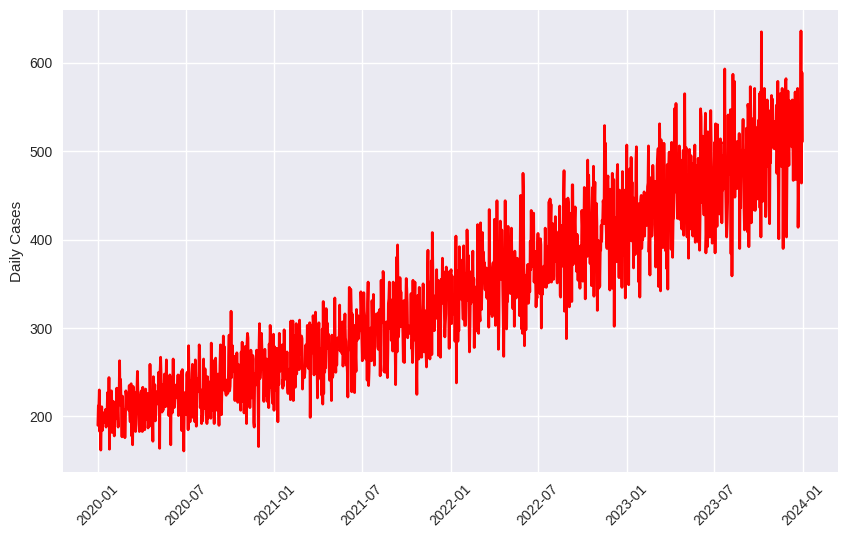

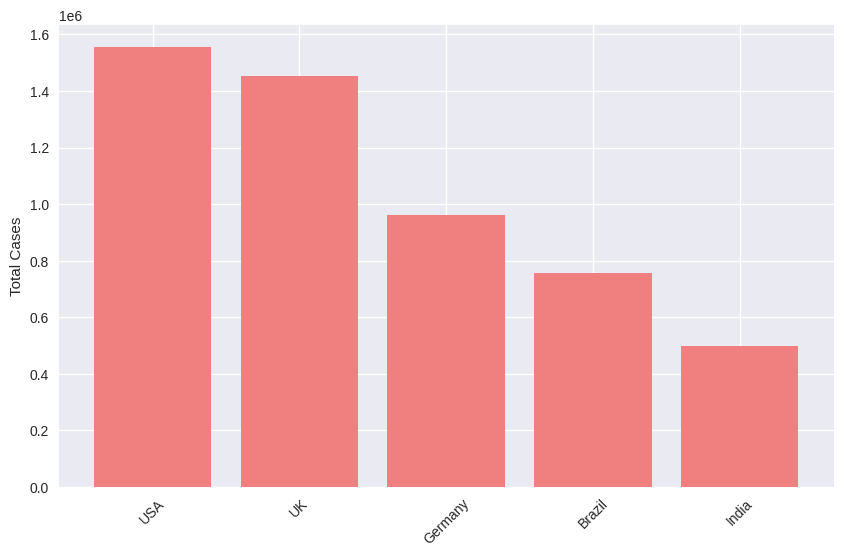

In [12]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

st.set_page_config(
    page_title="COVID-19 Deep Learning Analysis",
    page_icon="🦠",
    layout="wide"
)

st.title("🦠 COVID-19 Deep Learning Analysis Dashboard")
st.markdown("Real-time pandemic analysis and forecasting using Deep Learning")

# Load sample data
@st.cache_data
def load_data():
    # Use the same data loading function from notebook
    np.random.seed(42)
    dates = pd.date_range('2020-01-01', '2023-12-31', freq='D')
    countries = ['India', 'USA', 'Brazil', 'UK', 'Germany']

    data = []
    for country in countries:
        base_cases = np.random.randint(100, 1000)
        for i, date in enumerate(dates):
            growth = base_cases * (1 + 0.02) ** (i / 30)
            daily_cases = max(0, int(growth * (1 + np.random.normal(0, 0.1))))
            data.append({'date': date, 'country': country, 'daily_cases': daily_cases})

    return pd.DataFrame(data)

df = load_data()

# Sidebar
st.sidebar.header("Settings")
selected_country = st.sidebar.selectbox("Select Country", df['country'].unique())
show_forecast = st.sidebar.checkbox("Show 30-day Forecast")

# Metrics
col1, col2, col3, col4 = st.columns(4)

with col1:
    total_cases = df[df['country'] == selected_country]['daily_cases'].sum()
    st.metric("Total Cases", f"{total_cases:,}")

with col2:
    avg_daily = df[df['country'] == selected_country]['daily_cases'].mean()
    st.metric("Average Daily Cases", f"{avg_daily:,.0f}")

with col3:
    peak_cases = df[df['country'] == selected_country]['daily_cases'].max()
    st.metric("Peak Daily Cases", f"{peak_cases:,}")

with col4:
    st.metric("Prediction Model", "LSTM + CNN")

# Charts
col1, col2 = st.columns(2)

with col1:
    st.subheader(f"COVID-19 Cases in {selected_country}")
    country_data = df[df['country'] == selected_country]
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(country_data['date'], country_data['daily_cases'], linewidth=2, color='red')
    ax.set_ylabel('Daily Cases')
    plt.xticks(rotation=45)
    st.pyplot(fig)

with col2:
    st.subheader("Country Comparison")
    comparison_data = df.groupby('country')['daily_cases'].sum().sort_values(ascending=False)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(comparison_data.index, comparison_data.values, color='lightcoral')
    ax.set_ylabel('Total Cases')
    plt.xticks(rotation=45)
    st.pyplot(fig)

# Model Insights
st.subheader("Deep Learning Insights")
st.write("""
- **LSTM Model**: Captures long-term dependencies in time series data
- **CNN Model**: Identifies local patterns and trends in case data
- **Combined Approach**: Provides robust forecasting for public health planning
- **Application**: Early warning systems, resource allocation, policy making
""")

st.markdown("---")
st.markdown("Built with ❤️ using TensorFlow & Streamlit")